## Import boilerplate and setup

In [18]:
# first, change the working directory, if needed
import os
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
os.getcwd()

'/mnt/c/Users/aryam/Documents/school/2020/spring/cse283/BloodBrainClassifier'

In [19]:
# now, import whatever else we need
import sklearn
import importlib
import pandas as pd
from sklearn.svm import SVC
import scripts.starter as data
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Feature Selection

In [20]:
SUBSET_GENES_N = 1000
print("There are {} genes, total".format(len(data.data.columns)-1))
selected_genes = open('data/ranked_genes.tsv').read().split('\n')
selected_genes = selected_genes[:SUBSET_GENES_N]

There are 100 genes, total


In [21]:
importlib.reload(data)
data.data = data.data[selected_genes + ['group']]
data.split()
len(data.data.columns)

1001

## Train SVC model

In [22]:
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', C=.01))
clf.fit(data.X_train, data.y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.01, kernel='linear'))])

## Test SVC model and evaluate the model's performance

In [23]:
y_pred = clf.predict(data.X_test)

In [24]:
clf.score(data.X_test, data.y_test)

0.42424242424242425

Wow, that's pretty terrible. Is there any way we can improve that?

First, let's ask ourselves what the model might be doing wrong. Let's compare the predictions to the true labels.

In [25]:
pd.concat((data.y_test, pd.Series(y_pred, index=data.y_test.index)), axis=1)

,group,0
sample,,
N_7_01_1,0,1
AD_7_06_1,1,1
N_3_03_1,0,1
N_9_08_1,0,1
N_5_06_1,0,1
N_2_03_1,0,1
N_8_07_1,0,0
AD_2_02_1,1,1
AD_11_02_1,1,0


In [26]:
clf.decision_function(data.X_test)

array([ 1.1798214 ,  0.78758489,  1.43847569,  1.50270004,  0.7195208 ,
        1.68706776, -0.12433376,  0.6133076 , -0.06830291,  0.48424161,
       -0.5395076 ,  0.9165756 , -0.27296358, -0.34092248,  0.64145183,
        1.59918019,  0.83271322,  0.47872101,  0.47484229, -0.17985034,
        0.28050484,  3.76031486,  0.90802714, -1.52404743, -0.13969343,
        0.27810171,  0.89231942,  0.51435677, -0.02975442, -0.04150706,
        1.0148728 , -0.12012791,  0.2565751 ])

## Could there be overfitting?
How does our model perform when given all of the data, compared to before?

In [27]:
clf.fit(data.X, data.y)
clf.score(data.X_test, data.y_test)

1.0

Hmmm.. perhaps

## Are the samples separable to begin with?
Let's take a look at the first two PCs against each other.

In [28]:
from sklearn.decomposition import PCA

<AxesSubplot:xlabel='0', ylabel='1'>

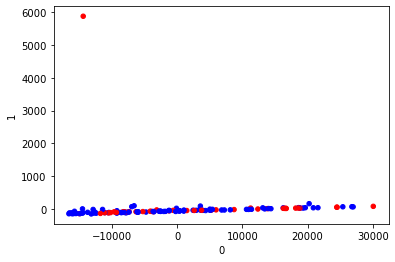

In [29]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(data.X)
pd.DataFrame(X_new).plot.scatter(x=0, y=1, color=['blue' if x else 'red' for x in data.data.group])

In [30]:
from sklearn.model_selection import cross_val_score
clf.fit(data.X_train, data.y_train)
sklearn.model_selection.cross_val_score(clf, data.X, data.y, cv=10)

array([0.5       , 0.85714286, 0.69230769, 0.69230769, 0.69230769,
       0.84615385, 0.76923077, 0.69230769, 0.61538462, 0.61538462])

In [31]:
import scripts.grid_search

model = sklearn.svm.SVC()
tuned_parameters = [{'kernel': ['poly'], 'C': [1, 0.000001], 'degree':[2, 5, 9]},
                    {'kernel': ['rbf'], 'C': [0.01, 0.8, 1, 1.5, 1.7, 2]},
                    {'kernel': ['linear'], 'C': [2, 1, 0.5, 0.1, 0.01]}]

scripts.grid_search.main(
    (data.X_train, data.y_train, data.X_test, data.y_test), SVC(), tuned_parameters, k=10
)

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 2, 'kernel': 'linear'}

Grid scores on development set:

0.414 (+/-0.015) for {'C': 1, 'degree': 2, 'kernel': 'poly'}
0.407 (+/-0.035) for {'C': 1, 'degree': 5, 'kernel': 'poly'}
0.586 (+/-0.330) for {'C': 1, 'degree': 9, 'kernel': 'poly'}
0.414 (+/-0.015) for {'C': 1e-06, 'degree': 2, 'kernel': 'poly'}
0.414 (+/-0.015) for {'C': 1e-06, 'degree': 5, 'kernel': 'poly'}
0.414 (+/-0.015) for {'C': 1e-06, 'degree': 9, 'kernel': 'poly'}
0.414 (+/-0.015) for {'C': 0.01, 'kernel': 'rbf'}
0.414 (+/-0.015) for {'C': 0.8, 'kernel': 'rbf'}
0.414 (+/-0.015) for {'C': 1, 'kernel': 'rbf'}
0.411 (+/-0.028) for {'C': 1.5, 'kernel': 'rbf'}
0.411 (+/-0.028) for {'C': 1.7, 'kernel': 'rbf'}
0.411 (+/-0.028) for {'C': 2, 'kernel': 'rbf'}
0.858 (+/-0.192) for {'C': 2, 'kernel': 'linear'}
0.858 (+/-0.192) for {'C': 1, 'kernel': 'linear'}
0.858 (+/-0.192) for {'C': 0.5, 'kernel': 'linear'}
0.858 (+/-0.192) for {'C': 0.1, 'ke

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [1, 1e-06], 'degree': [2, 5, 9],
                          'kernel': ['poly']},
                         {'C': [0.01, 0.8, 1, 1.5, 1.7, 2], 'kernel': ['rbf']},
                         {'C': [2, 1, 0.5, 0.1, 0.01], 'kernel': ['linear']}],
             scoring='f1_macro')